In [1]:
print("hello world")

hello world


## Step 1: Import necessary libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## Step 2: Load and Explore the Dataset

In [18]:
# Load dataset
df = pd.read_csv("heart.csv")

# Overview
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Step 3: Preprocessing

We'll use:
 - ```StandardScaler``` for numerical features
 - ```OneHotEncoder``` for categorical features

In [19]:
# Drop target variable for unsupervised clustering
X = df.drop(columns=["HeartDisease"])

# Identify feature types
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing: scale numeric and one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(), categorical_cols)
])


## Step 4: K-Means Clustering

Find optimal K (Elbow & Silhouette)

/home/w0lverys/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/w0lverys/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/w0lverys/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/w0lverys/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

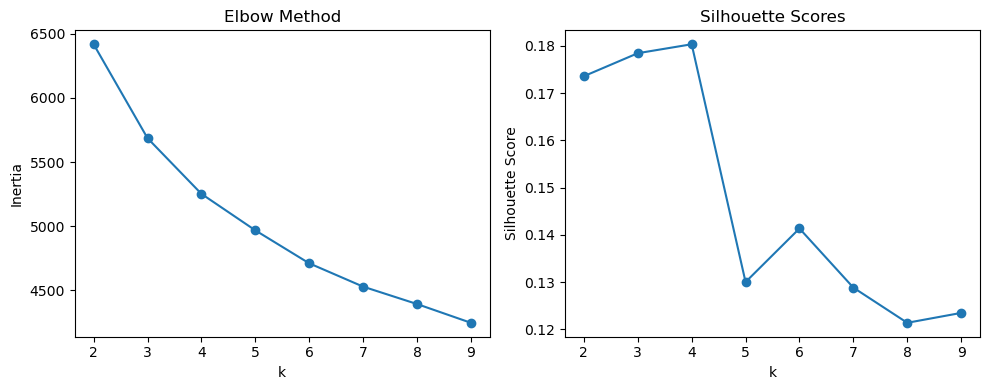

In [20]:
inertias = []
silhouettes = []
ks = range(2, 10)

for k in ks:
    model = Pipeline([
        ("preprocess", preprocessor),
        ("kmeans", KMeans(n_clusters=k, random_state=42))
    ])
    model.fit(X)
    labels = model.named_steps["kmeans"].labels_
    transformed = model.named_steps["preprocess"].transform(X)
    
    inertias.append(model.named_steps["kmeans"].inertia_)
    silhouettes.append(silhouette_score(transformed, labels))

# Plot Elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

# Plot Silhouette Scores
plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


## Step 5: Final KMeans with Best K = 4

In [21]:
best_k = 4

# Final pipeline
final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("kmeans", KMeans(n_clusters=best_k, random_state=42))
])

# Fit and assign cluster labels
final_pipeline.fit(X)
X_processed = preprocessor.fit_transform(X)
df["Cluster"] = final_pipeline.named_steps["kmeans"].labels_

# Final silhouette score
sil_score = silhouette_score(X_processed, df["Cluster"])
print(f"Silhouette Score with k=4: {sil_score:.4f}")


Silhouette Score with k=4: 0.1803


/home/w0lverys/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Step 6: PCA Visualization

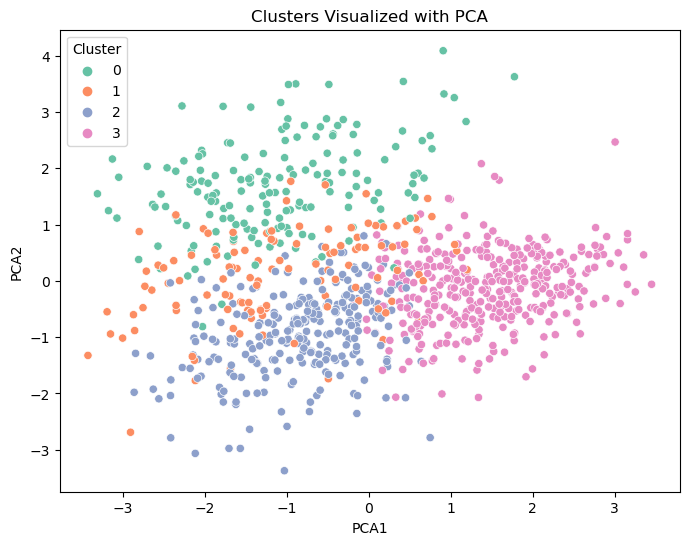

In [22]:
# PCA for 2D plot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_processed)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

# Plot PCA clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2")
plt.title("Clusters Visualized with PCA")
plt.show()

## Step 7: t-SNE Visualization

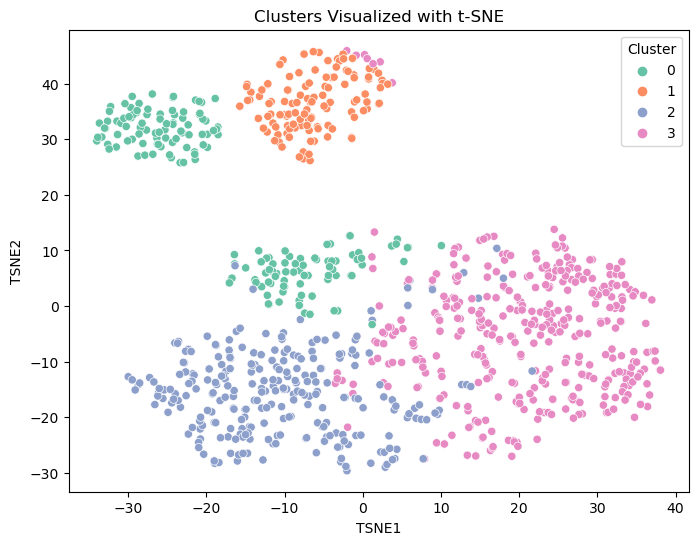

In [25]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X_processed)
df["TSNE1"] = tsne_result[:, 0]
df["TSNE2"] = tsne_result[:, 1]

# Plot t-SNE clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Cluster", palette="Set2")
plt.title("Clusters Visualized with t-SNE")
plt.show()

## Step 8: Cluster Profiling

In [26]:
# Compare mean values per cluster
cluster_profile = df.groupby("Cluster").mean(numeric_only=True)
display(cluster_profile)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,PCA1,PCA2,TSNE1,TSNE2
Cluster,,,,,,,,,,,
0,56.470238,129.803571,0.750000,0.529762,121.315476,0.819643,0.892857,-1.115620,1.675505,-17.186394,19.806866
1,58.635593,140.686441,254.525424,1.000000,132.457627,1.085593,0.694915,-1.075523,0.092182,-6.417551,36.671341
2,57.258555,135.509506,247.076046,0.000000,125.003802,1.731179,0.806084,-0.840396,-0.937323,-10.312914,-15.533769
3,47.853659,128.707317,236.739837,0.018970,153.669377,0.253388,0.173442,1.450840,-0.124245,20.349295,-4.806880


Cluster 0
- High heart disease prevalence: 89.3%
- Lower MaxHR: 121
- Moderate cholesterol: ~0.75 (could be missing values or zero-filled)
- Oldpeak: moderately high (0.82)
- Suggests high-risk group, possibly with missing cholesterol data.

Cluster 1
- Moderate heart disease prevalence: 69.5%
- Higher BP and cholesterol
- All FastingBS = 1 (possible diabetic patients)
- This group seems older, diabetic, hypertensive — also at risk.

Cluster 2
- Very high heart disease prevalence: 80.6%
- Highest Oldpeak (1.73) and high age
- Low MaxHR (125)
- Represents another high-risk group likely with ischemia or exercise-induced stress.

Cluster 3
- Low heart disease prevalence: 17.3%
- Younger (47.85), highest MaxHR
- Low BP, Oldpeak, and FastingBS
- Clearly a low-risk / healthy cluster.